# Introduction 
The experminet below tries to extend the idea that we hav eprocured in exp1. Instead of checking the error rate for normal bandlimited signals we will work with markov chains.

- We will start with markov chains backed up by some generator matrix.
- They will generate paths of "high resolution" from which we will sample ant try to reconstruct the entirety of the chain. Let say that we will do a decimation rate of 1-4 samples.
- Once we have those samples we passe them to a neural network which will likely have a BCE loss and will try to predict 0 or 1 in a specifc spot;
- Our hope is that we will see some point where there will be a *stark* drop in performance, probably due to an analogous phenomenon to sampling at subnyquist rate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from sp_sims.simulators.stochasticprocesses import RaceOfExponentials,TransitionMatrixBD

plt.style.use('rose-pine-dawn')
%load_ext autoreload
%autoreload 2

# Setup

## Constant Declarations

In [2]:
high_res_delta = 1 # For generating the dataset and later sample
baseline_rates = {"lam": 1/10,"mu":4/10}
sim_path_length = 256
used_path_length = 64 # So that we can let the process reach stationarity and take samples from stationary distribution
decimanation_factor = int(np.mean(1/np.array(list(baseline_rates.values())))//high_res_delta)
print(f"Decimation factor is {decimanation_factor}")
baseline_dataset_size = 2048
initial_state = 0

Decimation factor is 6


## Create Datasets

In [3]:
# Generate Basline dataset (the one we learn on )
def generate_state_tape(dataset_size: int, rates: dict, path_length: int, init_state: int = 0):
    sts = []
    for i in range(dataset_size):
        Q = np.array([[-rates["lam"],rates["lam"]],[rates["mu"],-rates["mu"]]])# Necessary to fit into TransitionMatrixBD generator
        # This generator will generate at the same interval so there is no need to have 
        generator = TransitionMatrixBD(Q, sampling_interval = high_res_delta)
        state_tape = generator.generate_history(init_state, path_length)
        sts.append(state_tape[-used_path_length:])
    return sts
state_tape = generate_state_tape(baseline_dataset_size,baseline_rates,used_path_length)

In [4]:
# Sample the dataset
sampled_sts = []
for i in range(len(state_tape)):
    sampled_sts.append(state_tape[i][::decimanation_factor])
print(f"Sampled state tape length is {len(sampled_sts[0])}")


Sampled state tape length is 11


In [5]:
a = [1,2,3,4]
b= a[::4]
print(b)

[1]


## Create Networks


In [6]:
from samprecon.reconstructors.markov_reconstructors import BCEReconstructor
import torch
# import binary cross entorpy loss
import torch.nn as nn
from samprecon.reconstructors.markov_reconstructors import BCEReconstructor
from torch.optim import Adam
from tqdm.notebook import tqdm

In [7]:
num_epochs = 10
batch_size = 16
input_size = 1 + used_path_length//decimanation_factor
bce_network = BCEReconstructor(input_size, used_path_length)
optimizer = Adam(bce_network.parameters(), lr=0.001)

criterion = nn.BCEWithLogitsLoss()

## Train Network

In [8]:
# Training
num_batches = len(sampled_sts)//batch_size
print(f'Executing the training with {num_batches} batches')
for epoch in tqdm(range(num_epochs),desc="Epochs",leave=False):
    batch_tqdm = tqdm(range(num_batches), desc="Batch",leave=True)
    for i in range(num_batches):
        batch_sts = torch.Tensor(sampled_sts[i*batch_size:(i+1)*batch_size]).to(torch.float).view(batch_size,-1)# Careful with len(sampled_sts)%batch_size != 0
        y_batch = torch.Tensor(state_tape[i*batch_size:(i+1)*batch_size]).to(torch.float).view(batch_size,-1)
        upsampled = bce_network(batch_sts)

        # Compute Loss
        loss = criterion(upsampled,y_batch)
        # Set batch_tqdm description
        batch_tqdm.set_description(f"Loss is {loss.item()}")
        batch_tqdm.update(1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Executing the training with 128 batches


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/128 [00:00<?, ?it/s]

/tmp/ipykernel_394245/3443470027.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035629/work/torch/csrc/utils/tensor_new.cpp:261.)
  batch_sts = torch.Tensor(sampled_sts[i*batch_size:(i+1)*batch_size]).to(torch.float).view(batch_size,-1)# Careful with len(sampled_sts)%batch_size != 0


Batch:   0%|          | 0/128 [00:00<?, ?it/s]

Batch:   0%|          | 0/128 [00:00<?, ?it/s]

Batch:   0%|          | 0/128 [00:00<?, ?it/s]

Batch:   0%|          | 0/128 [00:00<?, ?it/s]

Batch:   0%|          | 0/128 [00:00<?, ?it/s]

Batch:   0%|          | 0/128 [00:00<?, ?it/s]

Batch:   0%|          | 0/128 [00:00<?, ?it/s]

Batch:   0%|          | 0/128 [00:00<?, ?it/s]

Batch:   0%|          | 0/128 [00:00<?, ?it/s]

In [9]:
# Generate one more batch
batch = torch.Tensor(generate_state_tape(batch_size, baseline_rates, used_path_length)).to(torch.float).view(1,-1,64)
batch_sampled = batch[:,:,::decimanation_factor]
print(f"Batch shape is {batch.shape}")
bce_network.eval()
res = bce_network(batch_sampled)
loss = criterion(res,batch).detach().item()
siggy = nn.Sigmoid()

batch = batch.detach().numpy().squeeze()
batch_sampled = batch_sampled.detach().numpy().squeeze()
res = siggy(res).detach().numpy().squeeze()
# Hard set 0 or 1 instead of sigmoid. Threshold is 0.5

print(f"Average loss is {loss}")

Batch shape is torch.Size([1, 16, 64])
Average loss is 0.374397337436676


Shape of the three is (64,), (11,), (64,)
Shape of the three is (64,), (11,), (64,)
Shape of the three is (64,), (11,), (64,)


[]

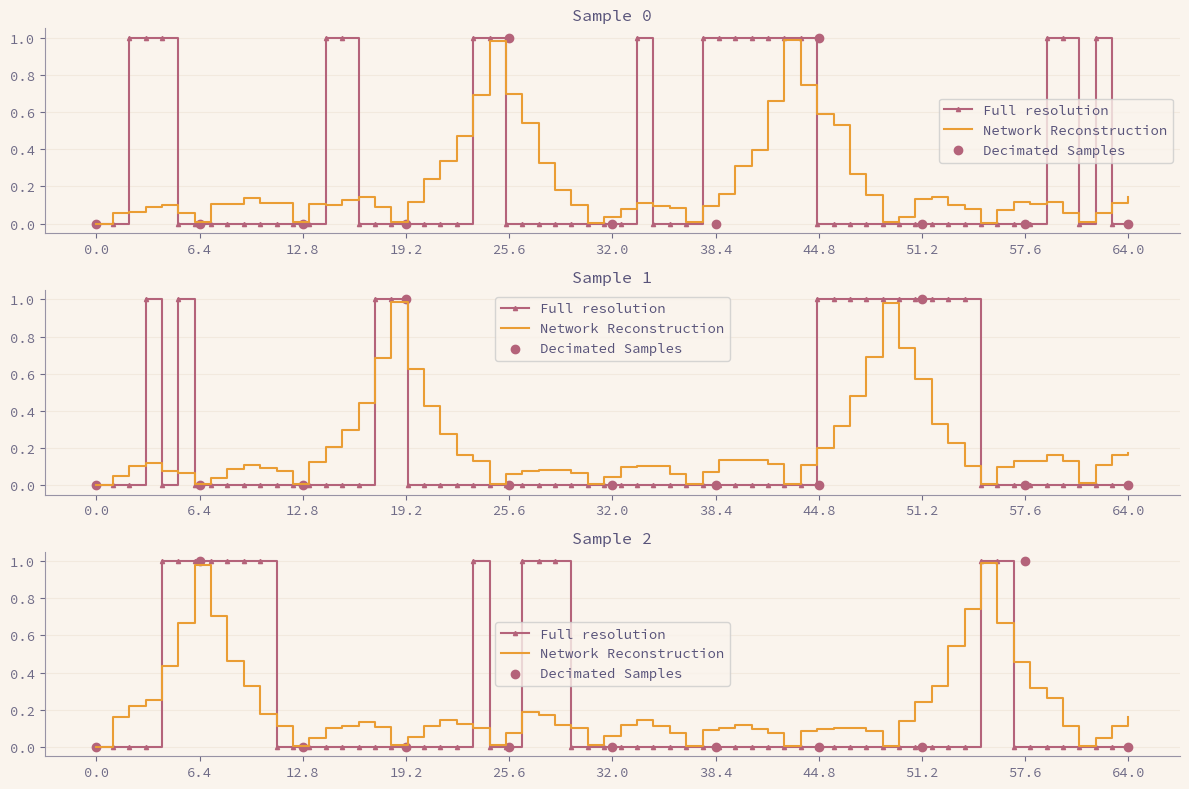

In [10]:
# Take few samples
num_examples = 3

# Plot the results
fig,axs = plt.subplots(3,1,figsize=(12,8))
for i in range(num_examples):
    full_res = batch[i]
    sample = batch_sampled[i]
    reconstruction = res[i]

    print(f"Shape of the three is {full_res.shape}, {sample.shape}, {reconstruction.shape}")
    high_res_x = np.linspace(0,used_path_length*high_res_delta, len(full_res))

    # Plot full resolution stair plot
    axs[i].plot(np.linspace(0,used_path_length*high_res_delta, len(full_res)),full_res,drawstyle="steps-post",label="Full resolution", marker="^",markersize=3)

    # Plot Samples
    x_tickies = np.linspace(0,used_path_length*high_res_delta, len(sample))
    axs[i].scatter(x_tickies,sample,label="Decimated Samples")
    axs[i].set_xticks(x_tickies)

    # Plot Reconstruction
    axs[i].plot(np.linspace(0,used_path_length*high_res_delta, len(reconstruction)),reconstruction,drawstyle="steps-post",label="Network Reconstruction")

    axs[i].legend()
    axs[i].set_title(f"Sample {i}")
fig.tight_layout()
plt.plot()

# Test Performance on Different Rates

In [11]:
## Generate surprises
##all_possible_lams = np.logspace(0.01,8,100, base=2)
#all_possible_lams = [1/10]
#
#available_surprises = []
## Generate Mus such that mu > lam 
#for lam in all_possible_lams:
#    for mu in np.logspace(np.log2(lam),8,100,base=2):
#        available_surprises.append({
#            "lam": lam,
#            "mu": mu
#        })
#print(f"Created {len(available_surprises)} available surprises")
#
## What if instead 

Created 100 available surprises


In [23]:
range_of_scales = np.logspace(-3,8,100)
available_surprises = [ {
    "lam": baseline_rates["lam"]*scale,
    "mu": baseline_rates["mu"]*scale
} for scale in range_of_scales]

In [25]:
# Create the surprise dataset
def multimodal_generation(rates_list, path_length, initial_state):
    surprise_tapes = []
    for rates in rates_list:
        Q = np.array([[-rates["lam"],rates["lam"]],[rates["mu"],-rates["mu"]]])# Necessary to fit into TransitionMatrixBD generator
        generator = TransitionMatrixBD(Q, sampling_interval=high_res_delta)
        state_tape = generator.generate_history(initial_state,path_length)
        surprise_tapes.append(state_tape[-used_path_length:])
    return surprise_tapes

#surprise_sts = multimodal_generation(available_surprises, sim_path_length, initial_state)

In [26]:
# Take the pretrained network and show it the surprise dataset
# Create a mapping from the surprise dataset to a calculaation performed on it
avg_exit_rate_mappign = { np.mean(list(dicto.values())) : dicto for dicto in available_surprises}
# Sort based on key 
sorted_surprise = sorted(avg_exit_rate_mappign.items(), key=lambda x: x[0])
print(f"We have realized len(sorted_surprise) = {len(sorted_surprise)} mappings")

We have realized len(sorted_surprise) = 100 mappings


In [27]:
# Once they are sorted we will generate a batch each and feed it to the network
# Then we will check for the loss and plot the results as a function of the surprise

losses = []
input_size = 1 + used_path_length//decimanation_factor
for avg_exit_rate, surprise in sorted_surprise:
    sts = []
    for b in range(256):
        Q = np.array([[-surprise["lam"],surprise["lam"]],[surprise["mu"],-surprise["mu"]]])# Necessary to fit into TransitionMatrixBD generator
        generator = TransitionMatrixBD(Q, high_res_delta)
        sts.append(generator.generate_history(initial_state,sim_path_length)[-used_path_length:])
    sts = torch.Tensor(sts).to(torch.float).view(1,-1,used_path_length)
    sts_sampled = sts[:,:,::decimanation_factor]
    res = bce_network(sts_sampled)
    losses.append(criterion(res,sts).detach().item())


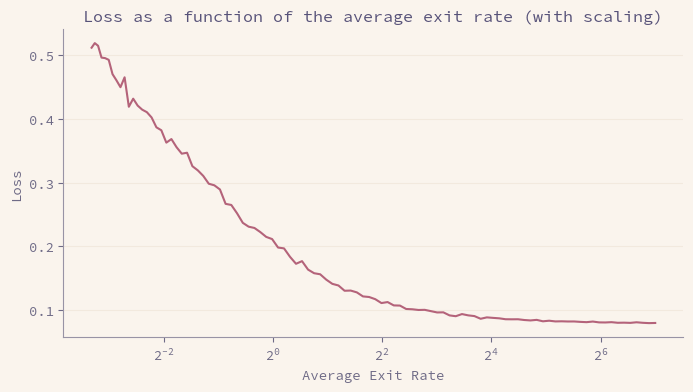

In [29]:
# Plot the losses
fig, axs = plt.subplots(1,1,figsize=(8,4))
axs.plot([x[0] for x in sorted_surprise],losses)
axs.set_xlabel("Average Exit Rate")
axs.set_xscale("log",basex=2)
axs.set_ylabel("Loss")
axs.set_title("Loss as a function of the average exit rate (with scaling)")
plt.show()

# Quesitons

1. How to prove similarities between using race of exponentials and sampling $P_{\Delta t}$
    - Statistica similarities to prove something analogous to isomorphism ?